In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import importlib
import config.models_config

importlib.reload(config.models_config)

<module 'config.models_config' from '/home/alice/btc_forecast/config/models_config.py'>

In [1]:
import sys
import os

# Allow notebook to import from ../btc_forecast/
sys.path.append(os.path.abspath("../"))

In [ ]:
from btc_forecast.data_loader import load_or_download
from btc_forecast.models_torch.registry import get_model


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json

from btc_forecast.data_loader import load_or_download
from btc_forecast.data_processing import train_test, normalize
from btc_forecast.windowed_dataset import WindowedDataset
from btc_forecast.models_torch.registry import get_model
from config import config, models_config

In [5]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [66]:
variables_used = ['close', 'open', 'high', 'low', "volume"]  # or fewer for testing
input_width = 200
label_width = 12
input_shape = (input_width, len(variables_used))

In [53]:
import matplotlib.pyplot as plt

def preview_training_data(dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, 1, figsize=(12, 4 * num_samples), sharex=True)

    for i in range(num_samples):
        x, y = dataset[i]
        x_np = x.numpy()
        y_np = y.numpy()

        for feature_idx in range(x_np.shape[1]):
            axs[i].plot(x_np[:, feature_idx], label=f'X: {variables_used[feature_idx]}', linestyle='-')

        for feature_idx in range(y_np.shape[1]):
            axs[i].plot(
                range(x_np.shape[0], x_np.shape[0] + y_np.shape[0]),
                y_np[:, feature_idx],
                label=f'Y: {variables_used[feature_idx]}',
                linestyle='--'
            )

        axs[i].legend()
        axs[i].set_title(f"Sample {i + 1}")
        axs[i].set_xlabel("Time step")
        axs[i].set_ylabel("Normalized Value")

    plt.tight_layout()
    plt.show()


In [50]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:001.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 25.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 23.1 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:

import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_config = {
    "input_width": 200,
    "label_width": 12,
    "hidden_size": 64,
    "num_layers": 2,
    "num_features": len(variables_used),
    }

class GRUStacked(nn.Module):
    def __init__(self, input_width, label_width, num_features, hidden_size=64, num_layers=2):
        super(GRUStacked, self).__init__()
        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, label_width * num_features)
        self.label_width = label_width
        self.num_features = num_features

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take the output from the last timestep
        out = self.fc(out)
        return out.view(-1, self.label_width, self.num_features)
    
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_width, label_width, num_features, hidden_size=64, num_layers=3, nhead=4):
        super(TransformerTimeSeries, self).__init__()
        self.input_width = input_width
        self.label_width = label_width
        self.num_features = num_features
        self.hidden_size = hidden_size

        self.input_projection = nn.Linear(num_features, hidden_size)

        self.positional_encoding = nn.Parameter(torch.randn(1, input_width, hidden_size))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=hidden_size * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(hidden_size, label_width * num_features)

    def forward(self, x):
        # x shape: (batch_size, input_width, num_features)
        x = self.input_projection(x)  # (batch_size, input_width, hidden_size)
        x = x + self.positional_encoding[:, :x.size(1), :]  # Add positional encoding

        encoded = self.transformer_encoder(x)  # (batch_size, input_width, hidden_size)
        last_token = encoded[:, -1, :]  # Take the last time step
        out = self.output_layer(last_token)  # (batch_size, label_width * num_features)

        return out.view(-1, self.label_width, self.num_features)

model =  TransformerTimeSeries(**model_config).to(device)
def train_model(
    coin,
    model,
    input_width=200,
    label_width=12,
    lr=1e-4,
    max_epochs=50,
    patience=8,
    
):

   

    df = load_or_download(coin)
    if 'volume' in df.columns:
        df["volume"] = np.log1p(df["volume"])
    df_norm = normalize(df, label_width=label_width, window=30)
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_norm[df_norm.columns] = scaler.fit_transform(df_norm)

    train_df, val_df, _ = train_test(df_norm[variables_used])

    train_ds = WindowedDataset(train_df, input_width, label_width, 0, variables_used)
    preview_training_data(train_ds)


    val_ds = WindowedDataset(val_df, input_width, label_width, 0, variables_used)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_weights = None
    early_stop_counter = 0

    



    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += loss_fn(preds, yb).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"📉 Epoch {epoch+1}: Train={train_loss:.4f} | Val={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("🛑 Early stopping")
                break

    return model, best_weights, train_losses, val_losses


📁 Loading BTCUSDT from /home/alice/btc_forecast/Data/BTCUSDT.csv


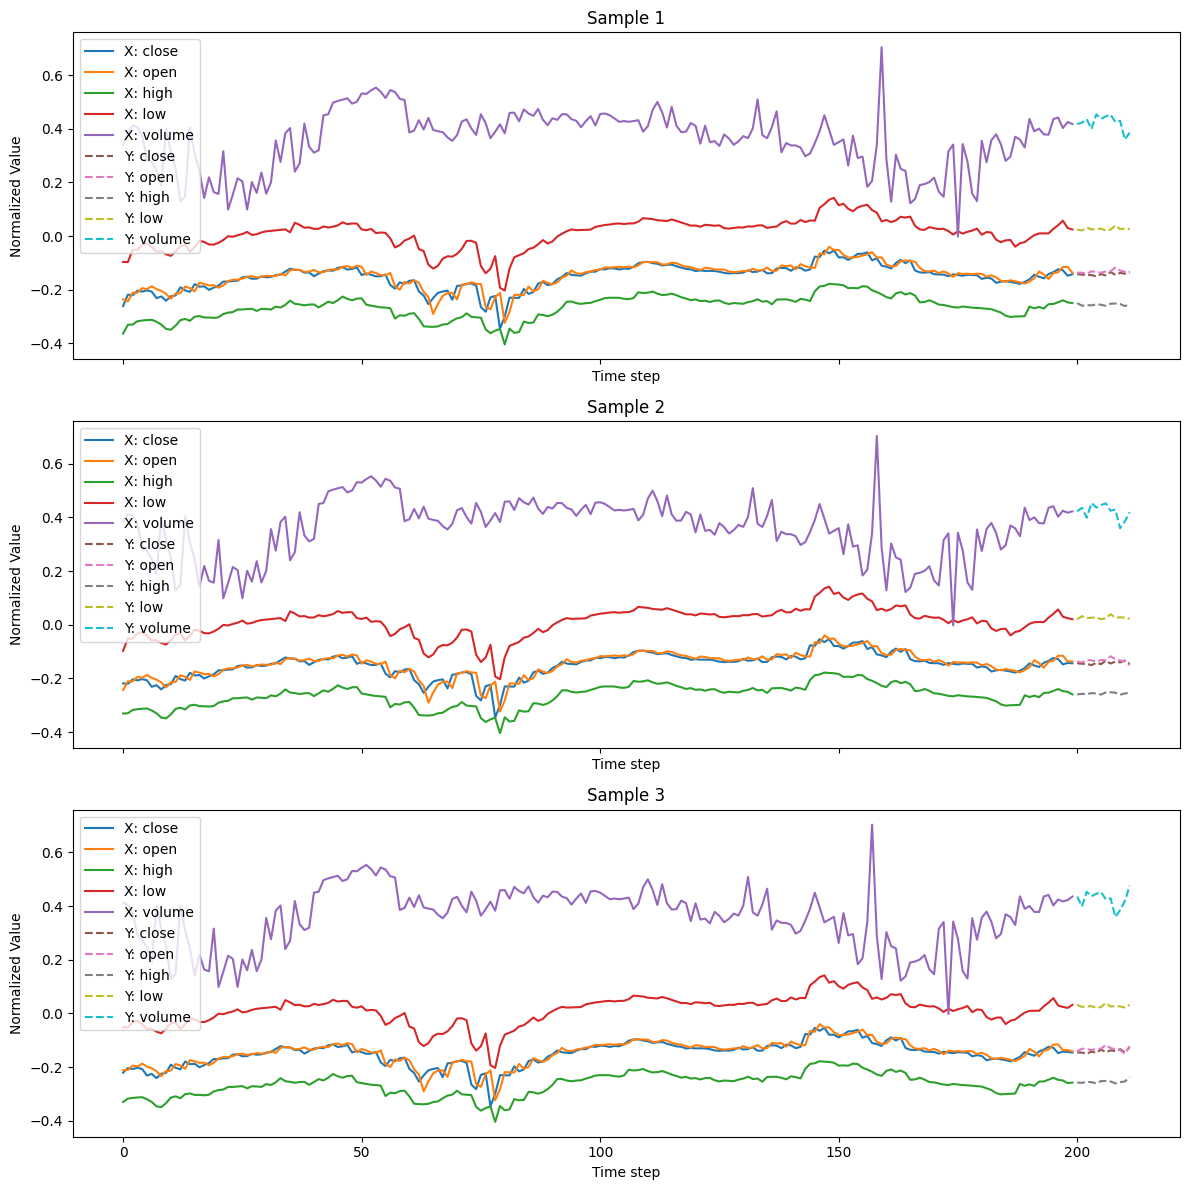

📉 Epoch 1: Train=0.0043 | Val=0.0031
📉 Epoch 2: Train=0.0029 | Val=0.0030
📉 Epoch 3: Train=0.0028 | Val=0.0028
📉 Epoch 4: Train=0.0027 | Val=0.0028
📉 Epoch 5: Train=0.0026 | Val=0.0026
📉 Epoch 6: Train=0.0025 | Val=0.0028
📉 Epoch 7: Train=0.0025 | Val=0.0025
📉 Epoch 8: Train=0.0025 | Val=0.0025
📉 Epoch 9: Train=0.0024 | Val=0.0025
📉 Epoch 10: Train=0.0024 | Val=0.0026
📉 Epoch 11: Train=0.0024 | Val=0.0025
📉 Epoch 12: Train=0.0024 | Val=0.0025
📉 Epoch 13: Train=0.0024 | Val=0.0024
📉 Epoch 14: Train=0.0024 | Val=0.0025
📉 Epoch 15: Train=0.0024 | Val=0.0025
📉 Epoch 16: Train=0.0023 | Val=0.0024
📉 Epoch 17: Train=0.0023 | Val=0.0025
📉 Epoch 18: Train=0.0023 | Val=0.0025
🛑 Early stopping


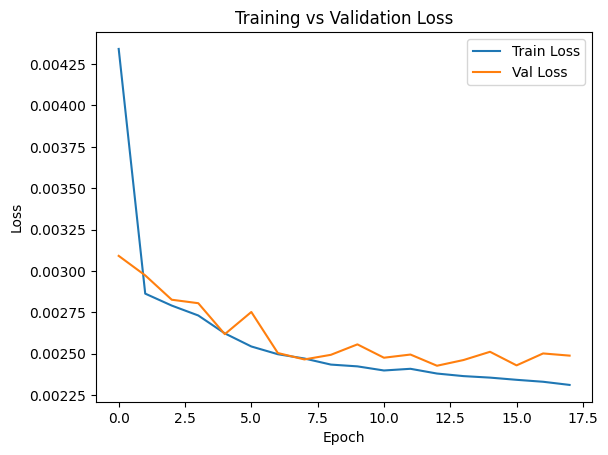

In [68]:

model, weights, train_l, val_l = train_model(
    coin="BTCUSDT",
    model=model,
    input_width=200,
    label_width=12,
    lr=1e-3,
    max_epochs=40,
    patience=5
)

plot_losses(train_l, val_l)

# Optionally save
#torch.save(weights, "models/ConvDenseTorch_BTCUSDT_best.pt")
